In [2]:
import cv2
import geopandas as gpd
import numpy as np
import rasterio as rst
import matplotlib.pyplot as plt
from rasterio.plot import show
import os
import pycrs
from rasterio.mask import mask

c:\Users\SIG01\.conda\envs\gpd_env\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


<AxesSubplot:>

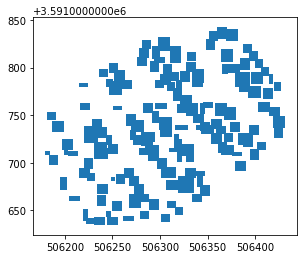

In [3]:
gdf = gpd.read_file('shapes/detected areas.shp')
gdf.plot()

In [4]:
gdf.sample(3)

,FID,LAYER,NAME,geometry
71,125,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506294.502 3591763.179, 506307.082 3..."
136,190,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506393.099 3591781.038, 506406.738 3..."
38,92,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506249.704 3591659.822, 506259.763 3..."


In [5]:
raster = rst.open('rasters/odm_orthophoto/odm_orthophoto.tif') 


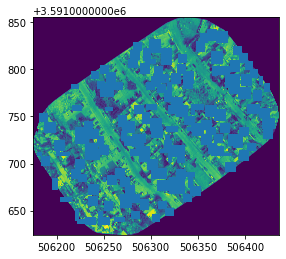

<AxesSubplot:>

In [6]:

gdf.plot()
show((raster, 1))

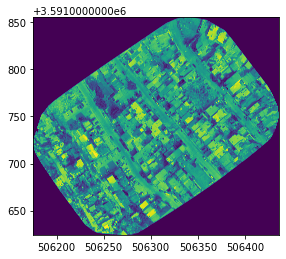

<AxesSubplot:>

In [7]:
show((raster, 1))

In [8]:
print(gdf.crs)
print(raster.crs)

epsg:32611
EPSG:32611


In [9]:
bbox = gdf.loc[1,'geometry'].bounds
bbox

(506181.58622522047, 3591744.51927678, 506190.925890157, 3591753.6189503283)

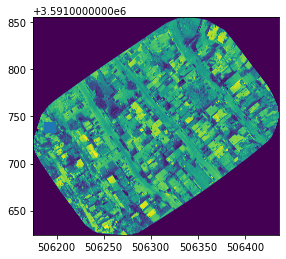

<AxesSubplot:>

In [10]:

gdf.loc[[0],'geometry'].plot()

show((raster, 1))



In [11]:

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [12]:

coords = getFeatures(gdf.loc[[0],'geometry'])
print(coords)

[{'type': 'Polygon', 'coordinates': [[[506186.8260372405, 3591744.199288261], [506199.3855866623, 3591744.199288261], [506199.38558666257, 3591732.199718749], [506186.8260372407, 3591732.199718749], [506186.8260372405, 3591744.199288261]]]}]


In [13]:

out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True)

In [14]:
out_meta = raster.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 13070, 'height': 11563, 'count': 4, 'crs': CRS.from_epsg(32611), 'transform': Affine(0.01999866525552078, 0.0, 506175.0464598688,
       0.0, -0.019999899778621096, 3591855.435297619)}


In [15]:
raster.crs.to_proj4()

'+init=epsg:32611'

In [16]:
epsg_code = int(raster.crs.data['init'][5:])
print(epsg_code)

32611


In [17]:


out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

In [18]:
pycrs.parse.from_epsg_code(epsg_code).to_proj4()

'+proj=utm +datum=WGS84 +ellps=WGS84 +a=6378137.0 +rf=298.257223563 +pm=0  +units=m +axis=enu +no_defs'

In [19]:


out_tif = os.path.join('rasters/odm_orthophoto/', "Helsinki_Masked.tif")

In [20]:
len(out_img)

4

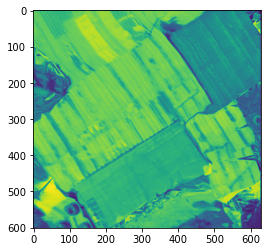

In [21]:

plt.imshow(out_img[1])

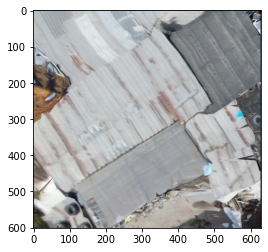

In [22]:
img_combined = cv2.merge((out_img[0],out_img[1],out_img[2]))

plt.imshow(img_combined)

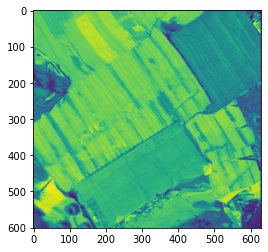

In [23]:
gray = cv2.cvtColor(img_combined,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)


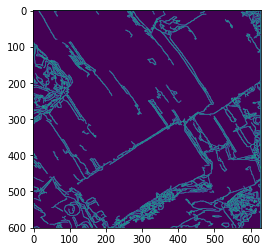

In [24]:
edged = cv2.Canny(gray, 30, 200)
plt.imshow(edged)

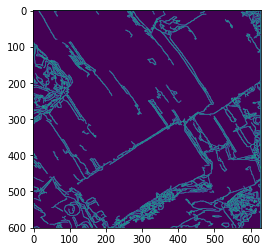

In [25]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(edged)

In [26]:
print("Number of Contours found = " + str(len(contours)))

Number of Contours found = 267


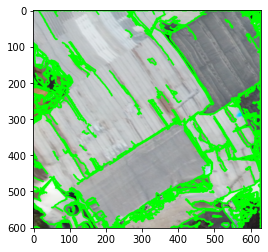

In [27]:
cv2.drawContours(img_combined, contours, -1, (0,255,0), 3)

plt.imshow(img_combined)

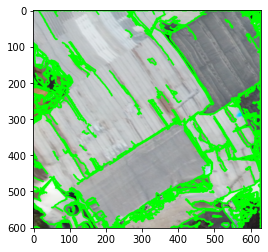

In [28]:
cv2.drawContours(img_combined, contours, -1, (0,255,0), 3)

plt.imshow(img_combined)

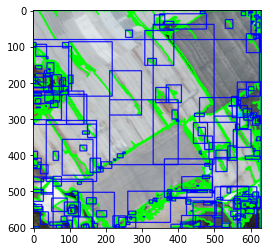

In [29]:

for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_combined,(x,y),(x+w,y+h),(0,0,255),2)    
    plt.imshow(img_combined)

In [30]:
cnt = contours[0]
M = cv2.moments(cnt)
print( M )

{'m00': 1.0, 'm10': 251.0, 'm01': 598.5, 'm20': 63001.166666666664, 'm11': 150223.41666666666, 'm02': 358202.3333333333, 'm30': 15813376.5, 'm21': 37706156.416666664, 'm12': 89908685.91666667, 'm03': 214384196.25, 'mu20': 0.16666666666424135, 'mu11': -0.08333333334303461, 'mu02': 0.08333333331393078, 'mu30': 1.862645149230957e-09, 'mu21': 1.4515535440295935e-09, 'mu12': 2.4738255888223648e-08, 'mu03': 2.9802322387695312e-08, 'nu20': 0.16666666666424135, 'nu11': -0.08333333334303461, 'nu02': 0.08333333331393078, 'nu30': 1.862645149230957e-09, 'nu21': 1.4515535440295935e-09, 'nu12': 2.4738255888223648e-08, 'nu03': 2.9802322387695312e-08}


In [31]:

def get_contour_areas(contours):

    all_areas= []

    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)

    return all_areas

areas = get_contour_areas(contours)





In [34]:
areas[0:5]

[1.0, 2.0, 3.0, 0.0, 7.5]

In [36]:

sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


largest_item= sorted_contours[0]

cv2.drawContours(img_combined, largest_item, -1, (255,0,0),10)
cv2.imshow('Largest Object', img_combined)





: 

In [35]:
cv2.drawContours(img_combined, smallest_item, -1, (255,0,0),10)
cv2.waitKey(0)
cv2.imshow('Smallest Object', img_combined)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Can't parse 'contours'. Input argument doesn't provide sequence protocol
>  - Can't parse 'contours'. Input argument doesn't provide sequence protocol
